 <a name="1"></a>
# <span style="color:green">Исследование надёжности заёмщиков <span>


Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество
детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о
платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели кредитного скоринга — специальной
системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.


# 1. Импорт библиотек и чтение данных

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objs as go
import plotly.express as px
from plotly import tools
from plotly.offline import init_notebook_mode, iplot
from pymystem3 import Mystem
from collections import Counter

In [52]:
df = pd.read_csv('datasets/preprocessing_project.csv')
df_copy = df.copy(deep=True)
df.head(1)

children  days_employed  dob_years education  education_id  \
0         1   -8437.673028         42    высшее             0   

     family_status  family_status_id gender income_type  debt   total_income  \
0  женат / замужем                 0      F   сотрудник     0  253875.639453   

         purpose  
0  покупка жилья

# 2. Проверка данных и предварительный анализ



In [53]:
df.shape

(21525, 12)

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


#### Информация о столбцах

* `children` — количество детей в семье
* `days_employed` — общий трудовой стаж в днях
* `dob_years` — возраст клиента в годах
* `education` — уровень образования клиента
* `education_id` — идентификатор уровня образования
* `family_status` — семейное положение
* `family_status_id` — идентификатор семейного положения
* `gender` — пол клиента
* `income_type` — тип занятости
* `debt` — имел ли задолженность по возврату кредитов
* `total_income` — ежемесячный доход
* `purpose` — цель получения кредита

In [55]:
df.describe(include='all')

children  days_employed     dob_years education  education_id  \
count   21525.000000   19351.000000  21525.000000     21525  21525.000000   
unique           NaN            NaN           NaN        15           NaN   
top              NaN            NaN           NaN   среднее           NaN   
freq             NaN            NaN           NaN     13750           NaN   
mean        0.538908   63046.497661     43.293380       NaN      0.817236   
std         1.381587  140827.311974     12.574584       NaN      0.548138   
min        -1.000000  -18388.949901      0.000000       NaN      0.000000   
25%         0.000000   -2747.423625     33.000000       NaN      1.000000   
50%         0.000000   -1203.369529     42.000000       NaN      1.000000   
75%         1.000000    -291.095954     53.000000       NaN      1.000000   
max        20.000000  401755.400475     75.000000       NaN      4.000000   

          family_status  family_status_id gender income_type          debt  \
count             21525      21525.000000  21525       21525  21525.000000   
unique                5               NaN      3           8           NaN   
top     женат / замужем               NaN      F   сотрудник           NaN   
freq              12380               NaN  14236       11119           NaN   
mean                NaN          0.972544    NaN         NaN      0.080883   
std                 NaN          1.420324    NaN         NaN      0.272661   
min                 NaN          0.000000    NaN         NaN      0.000000   
25%                 NaN          0.000000    NaN         NaN      0.000000   
50%                 NaN          0.000000    NaN         NaN      0.000000   
75%                 NaN          1.000000    NaN         NaN      0.000000   
max                 NaN          4.000000    NaN         NaN      1.000000   

        total_income  purpose  
count   1.935100e+04    21525  
unique           NaN       38  
top              NaN  свадьба  
freq             NaN      797  
mean    1.674223e+05      NaN  
std     1.029716e+05      NaN  
min     2.066726e+04      NaN  
25%     1.030532e+05      NaN  
50%     1.450179e+05      NaN  
75%     2.034351e+05      NaN  
max     2.265604e+06      NaN

In [56]:
df.duplicated().sum()

54

In [57]:
df.sample(10)

children  days_employed  dob_years            education  education_id  \
20660         0   -1102.019223         58              среднее             1   
3219          0   -1008.809451         44               высшее             0   
805           1    -324.039441         41              среднее             1   
7095          0   -1498.372878         27  неоконченное высшее             2   
18589         1   -1965.665152         27              среднее             1   
886           0  330531.022344         57              Среднее             1   
15545         0  354302.265733         60              среднее             1   
1008          0  386310.895293         66              среднее             1   
12970         0   -3017.005276         49              Среднее             1   
9408          0   -2139.352596         53              СРЕДНЕЕ             1   

          family_status  family_status_id gender income_type  debt  \
20660   женат / замужем                 0      M   сотрудник     0   
3219    женат / замужем                 0      F   сотрудник     0   
805     женат / замужем                 0      M   компаньон     0   
7095   гражданский брак                 1      F   сотрудник     0   
18589   женат / замужем                 0      F   сотрудник     0   
886    гражданский брак                 1      F   пенсионер     0   
15545   женат / замужем                 0      F   пенсионер     0   
1008    женат / замужем                 0      M   пенсионер     0   
12970   женат / замужем                 0      F   сотрудник     0   
9408    женат / замужем                 0      F   сотрудник     0   

        total_income                                purpose  
20660  291406.089955               операции с недвижимостью  
3219   153196.477309                                  жилье  
805    220455.458387  получение дополнительного образования  
7095   166908.225133                     высшее образование  
18589  111598.649534                                  жилье  
886    187609.031655                                свадьба  
15545  199798.831454                 профильное образование  
1008    55596.388141                          покупка жилья  
12970   85200.310646                 профильное образование  
9408    82884.374581                покупка жилья для сдачи

### Выводы по предварительному анализу

- Некачественное название столбцов [x]
- Дубликаты значений [x]
- Пропуски значений в столбцах стаж и ежемесячный доход [x]
- Отрицательные значения в столбце дети [x]
- Некоректные значения в столбце дети (20) [x]
- Отрицательные значения в столбце трудовой стаж [x]
- Столбец стаж тип данных [x]
- Некоректные данные в возрасте клиента (0)[x]
- Плавающий регистр в столбце образование [x]
- Некоректные данные в столбце пол (3 пола)[x]

# 3 Подготовка и очистка данных

## 3.1. Индексы и названия столбцов

In [58]:
df.columns.tolist()

['children',
 'days_employed',
 'dob_years',
 'education',
 'education_id',
 'family_status',
 'family_status_id',
 'gender',
 'income_type',
 'debt',
 'total_income',
 'purpose']

In [59]:
columns = ['number_of_children',
             'days_employed',
             'age',
             'education',
             'education_id',
             'family_status',
             'family_status_id',
             'gender',
             'income_type',
             'debt',
             'monthly_income',
             'credit_purpose']

In [60]:
# Переименовываем и проверяем столбцы
df.set_axis(columns, axis=1, inplace=True)
df.columns.tolist()

['number_of_children',
 'days_employed',
 'age',
 'education',
 'education_id',
 'family_status',
 'family_status_id',
 'gender',
 'income_type',
 'debt',
 'monthly_income',
 'credit_purpose']

## 3.2. Поиск дубликатов

In [61]:
df.duplicated().sum()

54

Как мы можем уидеть данные содержат 54 дубликата. Стоит обратить внимание и разобраться с причинами их возникновения.
Скорее всего они появились из-за ошибки правил валидации на сервере.

In [62]:
# удаляем дубликаты и сбрасываем индекс
df = df.drop_duplicates().reset_index(drop=True)

In [63]:
# Проверка 
df.duplicated().sum()

0

## 3.3. Поиск пропущенных значений

In [155]:
# разбирался с Series
null_percentage = df.isnull().sum()/len(df)*100
null_quantity = df.isnull().sum()
col_isnull = pd.concat([null_percentage, null_quantity], axis=1).sort_values(by=1, ascending=False)
col_isnull.columns = ['null_percentage','null_quantity']
col_isnull.head()


null_percentage  null_quantity
number_of_children              0.0              0
age                             0.0              0
education                       0.0              0
education_id                    0.0              0
family_status                   0.0              0

Мы наблюдаем что в столбцах 'monthly_income' и days_employed отсутствует около 10% значений.

❗️ **Второстипенная проблема отсутствующая в задачах исследования.**

Вариант для проработки 2 сценариев и обсуждения вопроса с заказчиком:

- Зависит от ситуации в настоящий момент - много задолжностей либо мало обращений

- Заполнение отсутсвующих данных значением медианы повысит шанс получения кредита (если подставим медиану то банк берет на себя дополнительные риски). Заполнение 0 - снизит (если подставим 0 то банк лишиться потенциальных клиентов)


## 3.4. Обработка отсутствующих значений

### 3.4.1. Обработка пропущенных значений столбца 'days_employed'

In [65]:
df['days_employed'].value_counts(dropna=False).head(5)

 NaN            2120
-1645.463049       1
-6620.396473       1
-1238.560080       1
-3047.519891       1
Name: days_employed, dtype: int64

В данном столбце 2174 нулевых значения. Так как значение столбца 'days_employed' количественное, заменим пропущенные значения в столбце на значение медианы

In [66]:
#Замена
df['days_employed'] = df['days_employed'].fillna(df['days_employed'].median())
# Проверка замены
df.days_employed.value_counts().head(5)

-1203.369529    2121
-986.927316        1
-1893.222792       1
-4236.274243       1
-6620.396473       1
Name: days_employed, dtype: int64

### 3.4.2. Обработка пропущенных значений столбца 'monthly_income'

In [67]:
df['monthly_income'].value_counts(dropna=False).head(5)

NaN              2120
133912.272223       1
182036.676828       1
122421.963500       1
198271.837248       1
Name: monthly_income, dtype: int64

В данном столбце как и в предыдущем примере 2175 нулевых значения. Этот столбец очень важен для анализа, так как ежемесячный доход это одна из главных метрик показателя платежеспособности клиента. Так как значение столбца 'monthly_income' количественное, заменим пропущенные значения в столбце на значение медианы

In [68]:
#Замена
df['monthly_income'] = df['monthly_income'].fillna(df['monthly_income'].median())
# Проверка замены
df['monthly_income'].value_counts().head()

145017.937533    2121
112874.418757       1
104381.857170       1
182036.676828       1
122421.963500       1
Name: monthly_income, dtype: int64

## 3.5. Обработка столбцов

Для большей наглядности исследование каждого столбца буду начинать с постоения диаграммы 'ящик с усами', что позволит взглянуть на выбросы и ознакомиться с данными более глубже

### 3.5.1 Количественные признаки

- number_of_children
- days_employed => years_employed
- age
- education_id
- family_status_id
- debt
- monthly_income

#### 3.5.1.1 Дети

In [69]:
children = px.box(df, y='number_of_children', title='Children')
children.show()

In [70]:
df['number_of_children'].value_counts()

 0     14107
 1      4809
 2      2052
 3       330
 20       76
-1        47
 4        41
 5         9
Name: number_of_children, dtype: int64

График четко показал на выброс. 20 детей это перебор, как и -1. Здесь можно пойти 2 путями либо посчить эти данные нерепрезентативными и удалить, либо посчитать, что произошла ошибка при заполнении и испраить 20 на 2, а -1 на 1.
Так как дети наряду с семейным положением это самая важная метрика в данном исследовании [Наверх к цели исследования](#1), то будем производить замену а не лишаться данных.

In [71]:
# Также можно происвести замену на 0
df['number_of_children'] = df['number_of_children'].replace([20,-1], [2, 1])

In [72]:
# Проверяем замену
df['number_of_children'].value_counts()

0    14107
1     4856
2     2128
3      330
4       41
5        9
Name: number_of_children, dtype: int64

#### 3.5.1.2 Трудовой стаж

In [73]:
days_employed = px.box(df, y='days_employed', title='Days employed')
days_employed.show()

In [74]:
df['days_employed'].describe()

count     21471.000000
mean      56702.605042
std      135060.747564
min      -18388.949901
25%       -2522.536607
50%       -1203.369529
75%        -382.945412
max      401755.400475
Name: days_employed, dtype: float64

Сразу же бросается в глаза выброс в район 400 тыс. Даже с учетом того, что в столбце стаж отображается в днях. Люди столько не работают и даже не живут ```400000/365 = 1095``` 😦.

❗️  Пока нам эта метрика не столь важна.


Далее мы изменим отрицательные значения на положительные и изменим тип данных на целое число, а также сделаем перевод дня в год


In [75]:
# Убираем отрицательные значения переводим в года, приводим к типу целое число и дропаем дни
df['days_employed'] = df['days_employed'].abs()
df['years_employed'] = df['days_employed']/365
df['years_employed'] = df['years_employed'].astype(int)
del df['days_employed']

#### 3.5.1.3 Возраст

In [76]:
age = px.box(df, y='age', title='Age')
age.show()

In [77]:
# считаем 0 значения
df[df['age'] == 0]['age'].count()

101

Из графика и подсчета количества значений с возрастом 0 видим что таких значений 101. Здесь можно разбросать данные по категориям, но так как данная метрика не участвует в анализе пока ее не трогаем

#### 3.5.1.4 Образование
Данный признак переведен из категориального в количественный

In [78]:
df['education_id'].value_counts()

1    15188
0     5251
2      744
3      282
4        6
Name: education_id, dtype: int64

#### 3.5.1.5 Семейное положение
Данный признак переведен из категориального в количественный

In [79]:
df['family_status_id'].value_counts()

0    12344
1     4163
4     2810
3     1195
2      959
Name: family_status_id, dtype: int64

#### 3.5.1.6 Задолженность по кредиту в прошлом

In [80]:
df['debt'].value_counts()

0    19730
1     1741
Name: debt, dtype: int64

#### 3.5.1.7  Ежемесячный доход

In [81]:
monthly_income = px.box(df, y='monthly_income', title='Мonthly income')
monthly_income.show()

Из данного столбца не совсем понятна единица измерения. Максимум  более 2 млн., медиана около 150000, а минимум 20000.

In [82]:
# Посмотрим сколько людей получают в месяц более 150000
df[df['monthly_income'] > 150000].count().head(1)


number_of_children    9184
dtype: int64

### Приступим к изучению категориальных признаков

### 3.5.2 Категориальные признаки

- education
- family_status
- gender
- income_type	
- credit_purpose

#### 3.5.2.1 Образование
Данный признактакже присутствует в выборке в количественном выражении

In [83]:
# Посмотрим на уникальные значения
df['education'].value_counts()

среднее                13705
высшее                  4710
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      668
ВЫСШЕЕ                   273
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
УЧЕНАЯ СТЕПЕНЬ             1
Ученая степень             1
Name: education, dtype: int64

In [84]:
# Приводим к нижнему регистру и проверяем
df['education'] = df['education'].str.lower()
df['education'].value_counts().head(5)

среднее                15188
высшее                  5251
неоконченное высшее      744
начальное                282
ученая степень             6
Name: education, dtype: int64

#### 3.5.2.2 Семейное положение

In [85]:
# Нижний регистр
df['family_status'] = df['family_status'].str.lower()

In [86]:
df.head(1)

number_of_children  age education  education_id    family_status  \
0                   1   42    высшее             0  женат / замужем   

   family_status_id gender income_type  debt  monthly_income credit_purpose  \
0                 0      F   сотрудник     0   253875.639453  покупка жилья   

   years_employed  
0              23

#### 3.5.2.2 Пол

In [87]:
df['gender'].value_counts()

F      14189
M       7281
XNA        1
Name: gender, dtype: int64

In [88]:
# Присутствует неизвестный пол, смотрим в какой строке и будем удалять
df[df['gender'] == 'XNA']

number_of_children  age            education  education_id  \
10690                   0   24  неоконченное высшее             2   

          family_status  family_status_id gender income_type  debt  \
10690  гражданский брак                 1    XNA   компаньон     0   

       monthly_income        credit_purpose  years_employed  
10690   203905.157261  покупка недвижимости               6

In [89]:
# drop строки с неизвестным полом, также можно кинуть монетку, а не удалять строку
# import random
# random.choice(['F', 'M'])

df.drop(df.index[[10690]], inplace=True)
# Проверяем удаление
df[df['gender'] == 'XNA']

Empty DataFrame
Columns: [number_of_children, age, education, education_id, family_status, family_status_id, gender, income_type, debt, monthly_income, credit_purpose, years_employed]
Index: []

#### 3.5.2.2 Тип занятости

In [90]:
# C типом занятости все в порядке
df['income_type'].value_counts()

сотрудник          11091
компаньон           5079
пенсионер           3837
госслужащий         1457
предприниматель        2
безработный            2
в декрете              1
студент                1
Name: income_type, dtype: int64

#### 3.5.2.2 Цель получения кредита

In [91]:
# Смотрим на уникальные значения
list_purposes = df['credit_purpose'].unique().tolist()
list_purposes

['покупка жилья',
 'приобретение автомобиля',
 'дополнительное образование',
 'сыграть свадьбу',
 'операции с жильем',
 'образование',
 'на проведение свадьбы',
 'покупка жилья для семьи',
 'покупка недвижимости',
 'покупка коммерческой недвижимости',
 'покупка жилой недвижимости',
 'строительство собственной недвижимости',
 'недвижимость',
 'строительство недвижимости',
 'на покупку подержанного автомобиля',
 'на покупку своего автомобиля',
 'операции с коммерческой недвижимостью',
 'строительство жилой недвижимости',
 'жилье',
 'операции со своей недвижимостью',
 'автомобили',
 'заняться образованием',
 'сделка с подержанным автомобилем',
 'получение образования',
 'автомобиль',
 'свадьба',
 'получение дополнительного образования',
 'покупка своего жилья',
 'операции с недвижимостью',
 'получение высшего образования',
 'свой автомобиль',
 'сделка с автомобилем',
 'профильное образование',
 'высшее образование',
 'покупка жилья для сдачи',
 'на покупку автомобиля',
 'ремонт жилью',
 '

In [92]:
len(list_purposes)

38

## 3.6 Лематизация

### 1 Вариант ресурсоемкий

In [94]:
# # ищем цели кредита
# m = Mystem()

# string_words = ','.join(list_purposes)
# lemma_lemma = p1.lemmatize(string_words)
# print(Counter(lemma_lemma))

Counter({' ': 59, ',': 37, 'покупка': 10, 'недвижимость': 10, 'автомобиль': 9, 'образование': 9, 'жилье': 7, 'с': 5, 'операция': 4, 'на': 4, 'свой': 4, 'свадьба': 3, 'строительство': 3, 'получение': 3, 'высокий': 3, 'дополнительный': 2, 'для': 2, 'коммерческий': 2, 'жилой': 2, 'подержать': 2, 'заниматься': 2, 'сделка': 2, 'приобретение': 1, 'сыграть': 1, 'проведение': 1, 'семья': 1, 'собственный': 1, 'со': 1, 'профильный': 1, 'сдача': 1, 'ремонт': 1, '\n': 1})


In [95]:
# # Ищем цели по другому
# m = Mystem()

# goals_list = []
# for i in list_purposes:
#     lemma = p.lemmatize(i)
#     goals_list += filter(lambda x: x not in [' ', '\n', 'с', 'со', 'на'], lemma)

# print(Counter(goals_list))

Counter({'покупка': 10, 'недвижимость': 10, 'автомобиль': 9, 'образование': 9, 'жилье': 7, 'операция': 4, 'свой': 4, 'свадьба': 3, 'строительство': 3, 'получение': 3, 'высокий': 3, 'дополнительный': 2, 'для': 2, 'коммерческий': 2, 'жилой': 2, 'заниматься': 2, 'сделка': 2, 'приобретение': 1, 'сыграть': 1, 'проведение': 1, 'семья': 1, 'собственный': 1, 'подержать': 1, 'подержанный': 1, 'профильный': 1, 'сдача': 1, 'ремонт': 1})


Из множества значений видим основные цели кредитов:
- автомобиль
- недвижимость
- образование
- свадьба
- жилье or операция == недвижимость

In [125]:
# составим список значений целей кредитов сначала было без жилья потом решил добавить
# purpose_category = ['автомобиль', 'образование', 'свадьба', 'недвижимость', 'жилье']

In [245]:
# m = Mystem()
# # Добавим значения  целей в новый столбец, но для начала напишем функцию 
# def categorize_goals(text):
#     lemmas = m.lemmatize(text)
#     for category in purpose_category:
#         if 'жилье' or 'операция'  in lemmas:
#             return 'недвижимость'
#         if category in lemmas:
#             return category

In [247]:
# Очень долго
# df['purpose_category'] = df['credit_purpose'].apply(categorize_goals)
# Заменяем None на NaN где не произошла замена целей кредита
# df_train.fillna(value=np.nan, inplace=True)

### 2 Вариант менее ресурсоемкий

In [254]:
m = Mystem()

In [258]:
#Создаю список уникальных значений в столбце purpose
purposes_list = df['credit_purpose'].unique()
lemmas = []
#Циклом лемматизирую содержание списка и добавляю лемметизированные значения в список lemmas
for phrase in purposes_list:
    lemmas.append(m.lemmatize(phrase))

In [259]:
#Создаю словарь, где ключами являются категории целей получения кредита
purposes_dict = {
   'жилье': [],
   'автомобиль': [],
   'образование': [],
   'свадьба': [],
   'недвижимость': []
}
#Циклом нахожу соответствия между конкретной категорией и элементом в списке уникальных значений столбца purpose. 
for i in range(len(lemmas)):
    if 'жилье' in lemmas[i]:
        purposes_dict['жилье'].append(purposes_list[i])
    elif 'автомобиль' in lemmas[i]:
        purposes_dict['автомобиль'].append(purposes_list[i])
    elif 'образование' in lemmas[i]:
        purposes_dict['образование'].append(purposes_list[i])
    elif 'свадьба' in lemmas[i]:
        purposes_dict['свадьба'].append(purposes_list[i])
    elif 'недвижимость' in lemmas[i]:
        purposes_dict['недвижимость'].append(purposes_list[i])

print(purposes_dict)

{'жилье': ['покупка жилья', 'операции с жильем', 'покупка жилья для семьи', 'жилье', 'покупка своего жилья', 'покупка жилья для сдачи', 'ремонт жилью'], 'автомобиль': ['приобретение автомобиля', 'на покупку подержанного автомобиля', 'на покупку своего автомобиля', 'автомобили', 'сделка с подержанным автомобилем', 'автомобиль', 'свой автомобиль', 'сделка с автомобилем', 'на покупку автомобиля'], 'образование': ['дополнительное образование', 'образование', 'заняться образованием', 'получение образования', 'получение дополнительного образования', 'получение высшего образования', 'профильное образование', 'высшее образование', 'заняться высшим образованием'], 'свадьба': ['сыграть свадьбу', 'на проведение свадьбы', 'свадьба'], 'недвижимость': ['покупка недвижимости', 'покупка коммерческой недвижимости', 'покупка жилой недвижимости', 'строительство собственной недвижимости', 'недвижимость', 'строительство недвижимости', 'операции с коммерческой недвижимостью', 'строительство жилой недвижимос

In [260]:
list = []
for j in df['credit_purpose']:
    for key, value in purposes_dict.items():
        if j in value:
            list.append(key)
df['purpose_category'] = list

In [263]:
df.head(1)

number_of_children  age education  education_id    family_status  \
0                   1   42    высшее             0  женат / замужем   

   family_status_id gender income_type  debt  monthly_income credit_purpose  \
0                 0      F   сотрудник     0   253875.639453  покупка жилья   

   years_employed  category_family category_monthly_income purpose_category  
0              23                0                 высокий            жилье

**Вывод:**
На этапе предобработки в данных обнаружились не только пропуски но и дубликаты. Удаление дубликатов и замена пропусков позволит провести анализ точнее. Поскольку сведения о ежемесячном доходе и трудовом стаже важны для анализа, не просто удаляем все пропущенные значения, заполняем их значением медианы. Также при работе с данными важно взглянуть и разобрать каждый столбец. После просмотра и предварительного анализа также провели лематизацию целей кредита 

# 4 Категоризация данных и определение зависимостей

**Зависимости**:
* Есть ли зависимость между наличием детей и возвратом кредита в срок?
* Есть ли зависимость между семейным положением и возвратом кредита в срок?
* Есть ли зависимость между уровнем дохода и возвратом кредита в срок?
* Как разные цели кредита влияют на его возврат в срок?

## 4.1 Зависимость между наличием детей и возвратом кредита в срок

In [149]:
df.head(1)

number_of_children  age education  education_id    family_status  \
0                   1   42    высшее             0  женат / замужем   

   family_status_id gender income_type  debt  monthly_income credit_purpose  \
0                 0      F   сотрудник     0   253875.639453  покупка жилья   

   years_employed  
0              23

In [184]:
df.groupby('number_of_children')['debt'].count()

number_of_children
0    14106
1     4856
2     2128
3      330
4       41
5        9
Name: debt, dtype: int64

In [187]:
# около 8% клиентов имели задолжность перед банком
df['debt'].mean()

0.08108989287377737

In [176]:
children_debt = df.pivot_table(index='number_of_children', values='debt')
type(children_debt) # pandas.core.frame.DataFrame
children_debt

debt
number_of_children          
0                   0.075358
1                   0.091639
2                   0.094925
3                   0.081818
4                   0.097561
5                   0.000000

**Вывод**
- Как видно из таблицы существует зависимость между наличием детей и возвратом кредита в срок, чем меньше детей тем меньше задолжностей перед банком имели клиенты, хотя это правило выбивается у семей которые имеют 3 детей, но здесь результат может откланяться из за небольшого количества наблюдений

## 4.2 Зависимость между семейным положением и возвратом кредита в срок

In [195]:
family_status_and_debt = df.pivot_table(index='family_status', 
                                        values=['debt', 'age']).sort_values(by='debt')
family_status_and_debt

age      debt
family_status                             
вдовец / вдова         56.503650  0.065693
в разводе              45.517992  0.071130
женат / замужем        43.548931  0.075421
гражданский брак       42.111965  0.093224
не женат / не замужем  38.363701  0.097509

#### Вывод:
- Из таблицы выше можно сказать что категория ```вдовец / вдова``` - самые ответственные плательщики 
- Больше всего пропусков у относительно молодых среди рассматриваемых групп со статусом ```не женат / не замужем```

**Теперь рассмотрим ситуацию когда вся выборка поделена на 2 категории по семейному положению:**
- одиноких и семейных

In [ ]:
def categorize_family(value):
    if value == 'женат / замужем' or value == 'гражданский брак':
        return 0
    return 1

In [201]:
df['category_family'] = df['family_status'].apply(categorize_family)
df.head()

number_of_children  age education  education_id     family_status  \
0                   1   42    высшее             0   женат / замужем   
1                   1   36   среднее             1   женат / замужем   
2                   0   33   среднее             1   женат / замужем   
3                   3   32   среднее             1   женат / замужем   
4                   0   53   среднее             1  гражданский брак   

   family_status_id gender income_type  debt  monthly_income  \
0                 0      F   сотрудник     0   253875.639453   
1                 0      F   сотрудник     0   112080.014102   
2                 0      M   сотрудник     0   145885.952297   
3                 0      M   сотрудник     0   267628.550329   
4                 1      F   пенсионер     0   158616.077870   

               credit_purpose  years_employed  category_family  
0               покупка жилья              23                0  
1     приобретение автомобиля              11                0  
2               покупка жилья              15                0  
3  дополнительное образование              11                0  
4             сыграть свадьбу             932                0

In [208]:
# Посмотрим распределение
df['category_family'].value_counts()

0    16506
1     4964
Name: category_family, dtype: int64

In [211]:
fam = df.pivot_table(index='category_family',values=['debt']).sort_values(by='debt')
fam

debt
category_family          
0                0.079910
1                0.085012

**Вывод:**
   - применив более общий подход можно сказать, что разница возврата кредита от семейного положения различается только на половину процента, что является не существенным значением.

## 4.3 Зависимость между уровнем дохода и возвратом кредита в срок

In [214]:
# Взглянем еще раз на ящиковую диаграмму и гистограмму
# monthly_income = px.box(df, y='monthly_income', title='Мonthly income')
monthly_income.show()

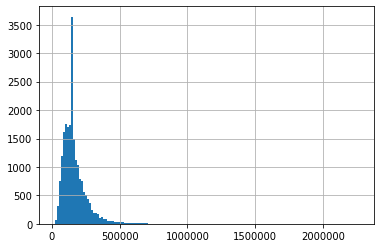

In [220]:
# Шпиль показывает медианное значение которое мы подставили ранее
hist = df['monthly_income'].hist(bins=150)

In [222]:
df['monthly_income'].describe()

count    2.147000e+04
mean     1.652083e+05
std      9.798577e+04
min      2.066726e+04
25%      1.076529e+05
50%      1.450179e+05
75%      1.957505e+05
max      2.265604e+06
Name: monthly_income, dtype: float64

In [228]:
# Пишем функцию для категоризации дохода по квантилям
def category_monthly(value):
    if value <= 1.076529e+05:
        return 'низкий'
    elif value <= 1.450179e+05:
        return 'ниже среднего'
    elif value <= 1.957505e+05:
        return 'выше среднего'    
    elif value > 1.957505e+05:
        return 'высокий'


In [229]:
df['category_monthly_income'] = df['monthly_income'].apply(category_monthly)

In [230]:
df.head()

number_of_children  age education  education_id     family_status  \
0                   1   42    высшее             0   женат / замужем   
1                   1   36   среднее             1   женат / замужем   
2                   0   33   среднее             1   женат / замужем   
3                   3   32   среднее             1   женат / замужем   
4                   0   53   среднее             1  гражданский брак   

   family_status_id gender income_type  debt  monthly_income  \
0                 0      F   сотрудник     0   253875.639453   
1                 0      F   сотрудник     0   112080.014102   
2                 0      M   сотрудник     0   145885.952297   
3                 0      M   сотрудник     0   267628.550329   
4                 1      F   пенсионер     0   158616.077870   

               credit_purpose  years_employed  category_family  \
0               покупка жилья              23                0   
1     приобретение автомобиля              11                0   
2               покупка жилья              15                0   
3  дополнительное образование              11                0   
4             сыграть свадьбу             932                0   

  category_monthly_income  
0                 высокий  
1           ниже среднего  
2           выше среднего  
3                 высокий  
4           выше среднего

In [231]:
df['category_monthly_income'].value_counts()

выше среднего    6427
высокий          5368
низкий           5368
ниже среднего    4307
Name: category_monthly_income, dtype: int64

In [241]:
df.pivot_table(index='category_monthly_income', values=['debt']).sort_values(by='debt')

debt
category_monthly_income          
высокий                  0.071349
низкий                   0.079545
выше среднего            0.086199
ниже среднего            0.087532

**Вывод:**

   Поцент задолжностей от уровня дохода ведут себя интересно.
   - У людей с высоким и низким ежемесячным доходом меньший процент задолжностей по кредиту и наоборот у людей со средним достатком этот показатель подрастает более чем на ```0,5 %```

## 4.4 Зависимость цели кредита на его возврат в срок

In [264]:
df.head()

number_of_children  age education  education_id     family_status  \
0                   1   42    высшее             0   женат / замужем   
1                   1   36   среднее             1   женат / замужем   
2                   0   33   среднее             1   женат / замужем   
3                   3   32   среднее             1   женат / замужем   
4                   0   53   среднее             1  гражданский брак   

   family_status_id gender income_type  debt  monthly_income  \
0                 0      F   сотрудник     0   253875.639453   
1                 0      F   сотрудник     0   112080.014102   
2                 0      M   сотрудник     0   145885.952297   
3                 0      M   сотрудник     0   267628.550329   
4                 1      F   пенсионер     0   158616.077870   

               credit_purpose  years_employed  category_family  \
0               покупка жилья              23                0   
1     приобретение автомобиля              11                0   
2               покупка жилья              15                0   
3  дополнительное образование              11                0   
4             сыграть свадьбу             932                0   

  category_monthly_income purpose_category  
0                 высокий            жилье  
1           ниже среднего       автомобиль  
2           выше среднего            жилье  
3                 высокий      образование  
4           выше среднего          свадьба

In [265]:
df['purpose_category'].value_counts()

недвижимость    6352
жилье           4461
автомобиль      4308
образование     4014
свадьба         2335
Name: purpose_category, dtype: int64

In [266]:
df.pivot_table(index='purpose_category', values=['debt']).sort_values(by='debt')

debt
purpose_category          
жилье             0.069043
недвижимость      0.074622
свадьба           0.079657
образование       0.092177
автомобиль        0.093547

**Вывод:**
   - Посмотрев на задолженности по категориям можно сделать вывод что кредит на ```автомобиль``` и  ```образование``` чаше всего может стать проблемным. Напротив клиенты которые берут кредит на  ```жилье``` и  ```недвижимость```, являются более надежными заемщиками.

# 5. Общие выводы 

В пункте 4 нашего анализа мы категоризировали данные и сравнивали различные метрики и смотрели их взаимосвязь с возвратом кредита в срок.
Теперь мы можем подвести итоги и посоветовать следующие рекомендации по выдаче кредитов, а также по дальнейшему сбору информации.

**Рекомендации по исследованию:**

- В первую очередь нужно обратить внимание на цели кредита и количество детей в семье. В целях нужно внимательно отнестись к клиентам которые берут кредит на  ```образование``` и ```автомобиль```, а увеличение количества детей конечно же создает дополнительную нагрузку на бюджет и своевременный возврат долгов.
- Во вторую очередь смотреть на уровень дохода, здесь не лучшим образом себя зарекомендовали клиенты со средней зарплатой и в последнюю очередь стоит обращать внимание на семейное положение, которое практически не влияет на количество задолжностей.

**Технические рекомендации:**
 - решить проблему записи дубликатов в базу данных
 - валидировать отрицательные цисла и некорректные (слишком высокие или слишком низкие) перед записью (количество детей, возраст) 
 - валидировать некорректные цисла (слишком высокие или слишком низкие) в возрасте и количестве детей
